In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
import os
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_data_dir = '/kaggle/input/garbage-classification/garbage_classification'

In [3]:
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'
val_dir = '/kaggle/working/valid'

In [4]:
class_directories = [d for d in os.listdir(main_data_dir) if os.path.isdir(os.path.join(main_data_dir, d))]

In [5]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [6]:
import shutil
from sklearn.model_selection import train_test_split
for class_dir in class_directories:
    class_path = os.path.join(main_data_dir, class_dir)
    
    # Get the list of all images in the class directory
    all_images = [img for img in os.listdir(class_path) if img.endswith('.jpg')]
    
    # Split the data into train, test, and validation sets
    train_images, test_val_images = train_test_split(all_images, test_size=0.3, random_state=42)
    test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=42)
    
    for img in train_images:
        src = os.path.join(class_path, img)
        dest = os.path.join(train_dir, class_dir, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)
    
    for img in test_images:
        src = os.path.join(class_path, img)
        dest = os.path.join(test_dir, class_dir, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)
    
    for img in val_images:
        src = os.path.join(class_path, img)
        dest = os.path.join(val_dir, class_dir, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Image dimensions
img_width, img_height = 224,224
input_shape = (img_width, img_height, 3)

# Data augmentation for training set
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data for training and validation
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_width, img_height), batch_size=32, class_mode='categorical')


# Generate batches of augmented data for testing
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_width, img_height), batch_size=32, class_mode='categorical')


Found 10854 images belonging to 12 classes.
Found 2333 images belonging to 12 classes.
Found 2328 images belonging to 12 classes.


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# ...

# Learning Rate Schedule
def learning_rate_schedule(epoch):
    if epoch < 5:
        return 1e-4
    elif epoch < 10:
        return 1e-5
    else:
        return 1e-6

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Model Checkpointing
checkpoint = ModelCheckpoint('/kaggle/working/best_vgg16_model.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True)

# VGG16
vgg16_model = Sequential()
vgg16_model.add(VGG16(weights='imagenet', include_top=False, input_shape=input_shape))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Flatten())
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(Dense(12, activation='softmax'))

# Fine-tune last few layers
for layer in vgg16_model.layers[:-6]:
    layer.trainable = False

vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = vgg16_model.fit(train_generator, epochs=30, 
                                validation_data=val_generator,
                                callbacks=[lr_scheduler, early_stopping, checkpoint])

# Evaluate on the test set
test_loss_vgg16, test_accuracy_vgg16 = vgg16_model.evaluate(test_generator)
print(f"Updated VGG16 Test Accuracy: {test_accuracy_vgg16}")


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
340/340 [==============================] - ETA: 0s - loss: 0.9609 - accuracy: 0.7045

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


340/340 [==============================] - 126s 357ms/step - loss: 0.9609 - accuracy: 0.7045 - val_loss: 0.7230 - val_accuracy: 0.7943 - lr: 1.0000e-04
Epoch 2/30
340/340 [==============================] - 119s 350ms/step - loss: 0.5516 - accuracy: 0.8261 - val_loss: 0.5291 - val_accuracy: 0.8504 - lr: 1.0000e-04
Epoch 3/30
340/340 [==============================] - 119s 350ms/step - loss: 0.4423 - accuracy: 0.8608 - val_loss: 0.4656 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 4/30
340/340 [==============================] - 119s 348ms/step - loss: 0.3664 - accuracy: 0.8801 - val_loss: 0.4548 - val_accuracy: 0.8551 - lr: 1.0000e-04
Epoch 5/30
340/340 [==============================] - 117s 345ms/step - loss: 0.3206 - accuracy: 0.8996 - val_loss: 0.5363 - val_accuracy: 0.8238 - lr: 1.0000e-04
Epoch 6/30
340/340 [==============================] - 119s 350ms/step - loss: 0.2738 - accuracy: 0.9146 - val_loss: 0.3887 - val_accuracy: 0.8877 - lr: 1.0000e-05
Epoch 7/30
340/340 [=============

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

# ...

# Learning Rate Schedule
def learning_rate_schedule(epoch):
    if epoch < 5:
        return 1e-4
    elif epoch < 10:
        return 1e-5
    else:
        return 1e-6

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Model Checkpointing
checkpoint = ModelCheckpoint('/kaggle/working/best_resnet_model.h5', 
                             monitor='val_accuracy', 
                             save_best_only=True)

# ResNet50
resnet_model = Sequential()
resnet_model.add(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape))
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(12, activation='softmax'))

# Fine-tune last few layers
for layer in resnet_model.layers[:-12]:
    layer.trainable = False

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = resnet_model.fit(train_generator, epochs=30, 
                                  validation_data=val_generator,
                                  callbacks=[lr_scheduler, early_stopping, checkpoint])

# Evaluate on the test set
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_generator)
print(f"Updated ResNet50 Test Accuracy: {test_accuracy_resnet}")


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/30
340/340 [==============================] - 161s 361ms/step - loss: 0.6137 - accuracy: 0.8124 - val_loss: 2.9822 - val_accuracy: 0.0587 - lr: 1.0000e-04
Epoch 2/30
340/340 [==============================] - 121s 355ms/step - loss: 0.2517 - accuracy: 0.9212 - val_loss: 1.4468 - val_accuracy: 0.6001 - lr: 1.0000e-04
Epoch 3/30
340/340 [==============================] - 121s 354ms/step - loss: 0.1763 - accuracy: 0.9456 - val_loss: 0.2800 - val_accuracy: 0.9147 - lr: 1.0000e-04
Epoch 4/30
340/340 [==============================] - 121s 354ms/step - loss: 0.1265 - accuracy: 0.9596 - val_loss: 0.1800 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 5/30
340/340 [==============================] - 120s 353ms/step - loss: 0.1103 - accuracy: 0.9651 - val_loss: 0.2500 - val_accuracy: 0.9276 - lr: 1.0000e-04
Epoch 6/30
340/340 [==============================] - 121s 355ms/step - loss: 0.0624 - accuracy: 0.9813 - val_loss: 0.09

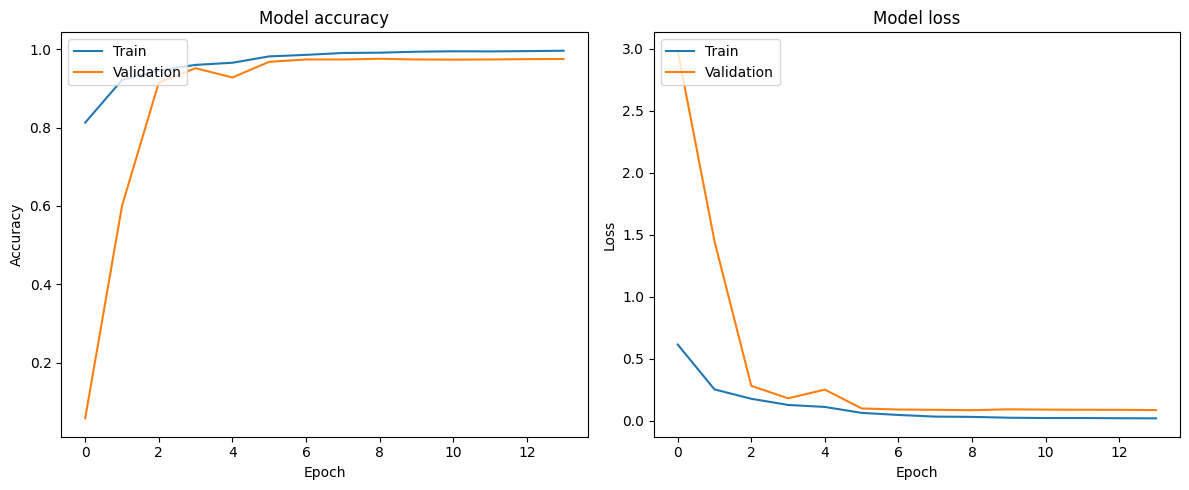

73/73 [==============================] - 5s 58ms/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       142
           1       0.08      0.08      0.08       148
           2       0.04      0.04      0.04        91
           3       0.07      0.07      0.07       134
           4       0.35      0.35      0.35       799
           5       0.04      0.04      0.04        94
           6       0.03      0.03      0.03       115
           7       0.07      0.07      0.07       157
           8       0.03      0.03      0.03       130
           9       0.11      0.11      0.11       297
          10       0.05      0.05      0.05       105
          11       0.08      0.08      0.08       116

    accuracy                           0.17      2328
   macro avg       0.09      0.09      0.09      2328
weighted avg       0.17      0.17      0.17      2328



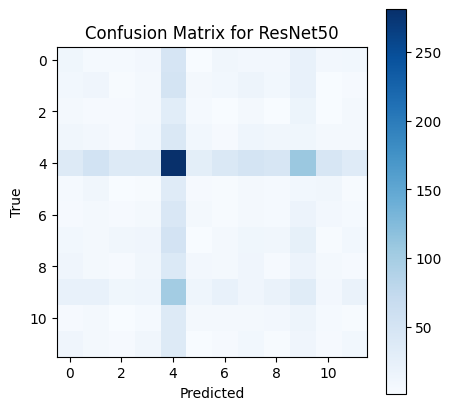

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the best VGG16 model
best_resnet_model = load_model('/kaggle/working/best_resnet_model.h5')

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Generate predictions for the test set
resnet_predictions = best_resnet_model.predict(test_generator)

# Convert predictions to class labels
resnet_pred_labels = np.argmax(resnet_predictions, axis=1)

# Convert one-hot encoded true labels to class labels
true_labels = test_generator.classes

# Generate classification report
print("Classification Report for ResNet50:")
print(classification_report(true_labels, resnet_pred_labels))

# Plot confusion matrix
conf_mat = confusion_matrix(true_labels, resnet_pred_labels)
plt.figure(figsize=(5, 5))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for ResNet50')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
